# Sea Ice Extent Timeseries
## **SOSE**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.07914ad8319748c888a7bcb807f089e5 Dashboard: /services/dask-gateway/clusters/staging.07914ad8319748c888a7bcb807f089e5/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [13]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["SOSE"].to_dask()

In [5]:
coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables

<ipython-input-5-048d900fe850>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
<ipython-input-5-048d900fe850>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables


In [6]:
dsr = dsr_before_drop.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords_before_drop.drop(['XC', 'YC', 'XG', 'YG'])

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 137 # 55.04˚S#107 # 60.04˚S 
left_lon =  310
right_lon = 880

In [8]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

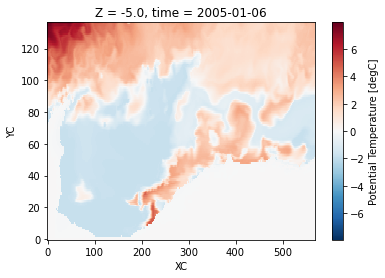

In [9]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()

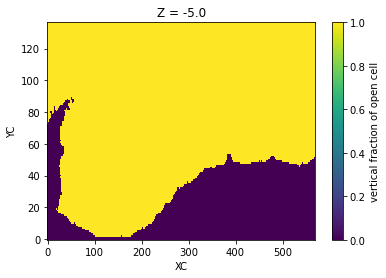

In [10]:
coords.hFacC[0].isel(**lat_range, **lon_range).plot()

In [11]:
mask = (coords.hFacC[0]>0).isel(**lat_range, **lon_range)

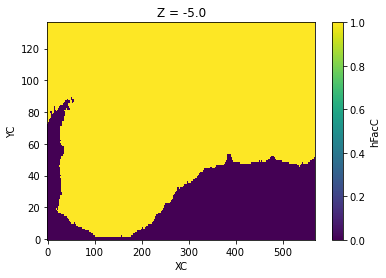

In [12]:
mask.plot()

In [14]:
dsr.SIarea

<xarray.DataArray 'SIarea' (time: 438, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

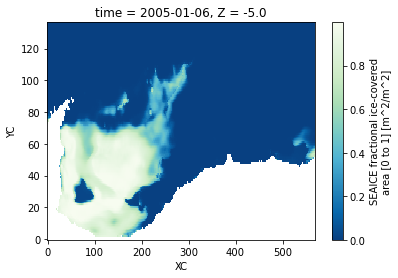

In [13]:
dsr.SIarea[0].isel(**lat_range, **lon_range).where(mask).plot(cmap='GnBu_r')

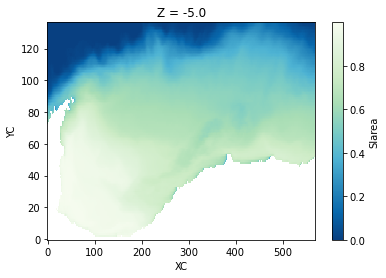

In [14]:
dsr.SIarea.isel(**lat_range, **lon_range).where(mask).mean(dim='time').plot(cmap='GnBu_r')

In [17]:
dsr.SIarea

<xarray.DataArray 'SIarea' (time: 438, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

In [9]:
coords.rA

<xarray.DataArray 'rA' (YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(320, 2160), dtype=float32, chunksize=(320, 2160), chunktype=numpy.ndarray>
Dimensions without coordinates: YC, XC
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [15]:
lon = coords_before_drop.XC.isel(**lon_range)
lat = coords_before_drop.YC.isel(**lat_range)
msi = dsr.SIarea.isel(**lat_range, **lon_range).where(mask).mean(dim='time').load()

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


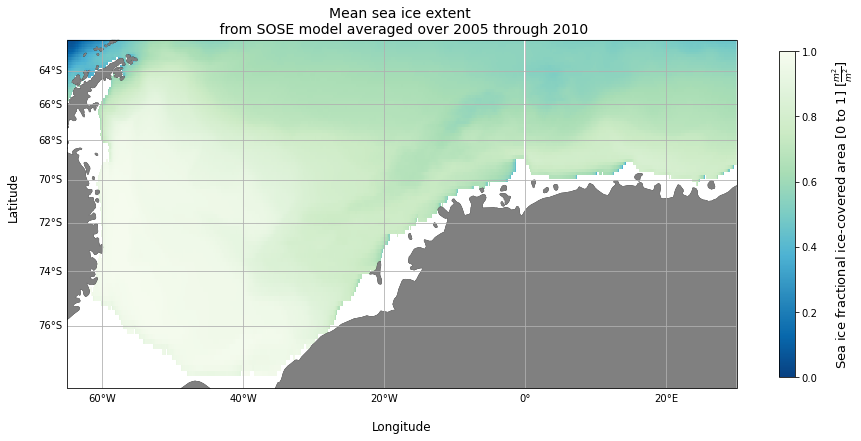

In [16]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, msi, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Sea ice fractional ice-covered area [0 to 1] $[\frac{m^2}{m^2}]$", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent \n from SOSE model averaged over 2005 through 2010', fontsize=14);

In [17]:
msi_06to10 = dsr.SIarea.isel(**lat_range, **lon_range).sel(time=slice('2006', '2010')).where(mask).mean(dim='time').load()

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


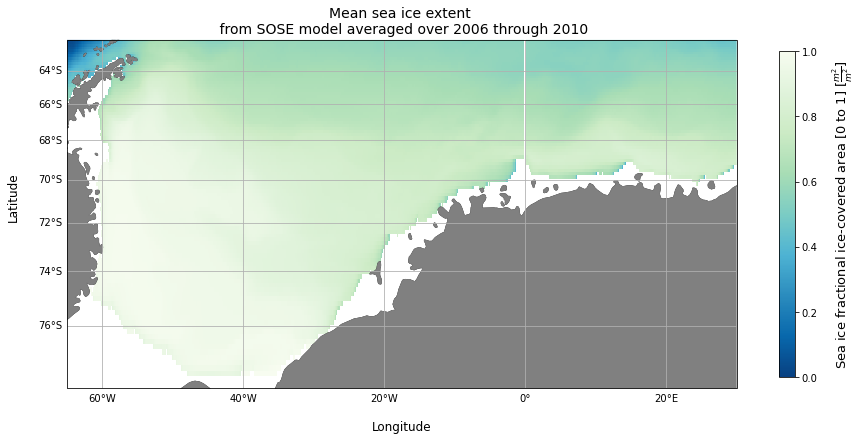

In [18]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, msi_06to10, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Sea ice fractional ice-covered area [0 to 1] $[\frac{m^2}{m^2}]$", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent \n from SOSE model averaged over 2006 through 2010', fontsize=14);

In [19]:
seaice = dsr.SIarea.isel(**lat_range, **lon_range).where(mask)
seaice_no05 = dsr.SIarea.isel(**lat_range, **lon_range).sel(time=slice('2006', '2010')).where(mask)

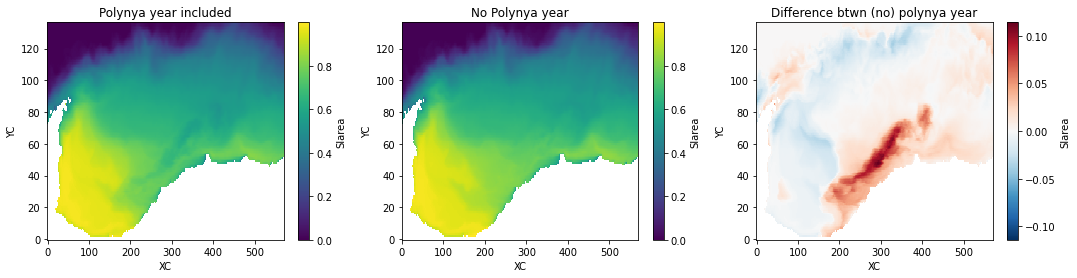

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,4))

seaice.mean('time').plot(ax=ax0)
seaice_no05.mean('time').plot(ax=ax1)
(seaice_no05.mean('time') - seaice.mean('time')).plot(ax=ax2)
ax0.set_title('Polynya year included')
ax1.set_title('No Polynya year')
ax2.set_title('Difference btwn (no) polynya year');

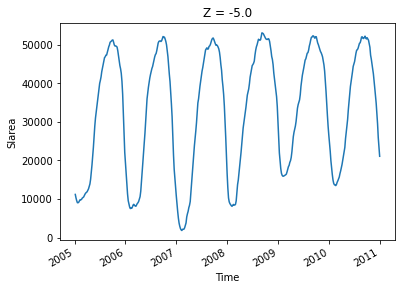

In [21]:
seaice.sum(['XC', 'YC']).plot();

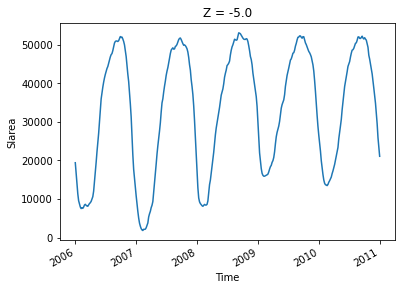

In [22]:
seaice_no05.sum(['XC', 'YC']).plot();

In [23]:
seaice_no05

<xarray.DataArray 'SIarea' (time: 366, YC: 137, XC: 570)>
dask.array<where, shape=(366, 137, 570), dtype=float32, chunksize=(1, 137, 570), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

In [24]:
area = coords.rA.isel(**lat_range, **lon_range)
weighted_area = seaice_no05 * area

In [25]:
weighted_area

<xarray.DataArray (time: 366, YC: 137, XC: 570)>
dask.array<mul, shape=(366, 137, 570), dtype=float32, chunksize=(1, 137, 570), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
Dimensions without coordinates: YC, XC

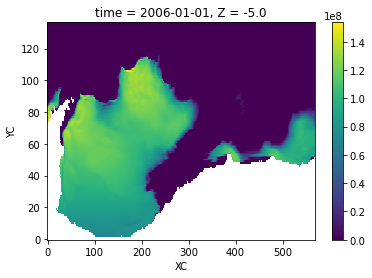

In [26]:
weighted_area[0].plot()

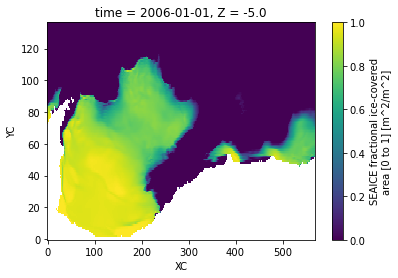

In [27]:
seaice_no05[0].plot()

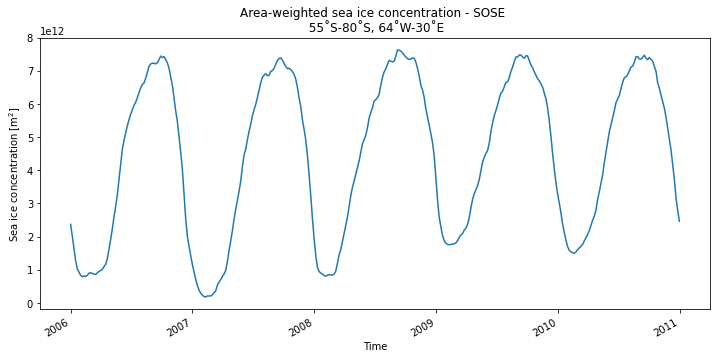

In [28]:
plt.figure(figsize=(12,5))
weighted_area.sum(['XC', 'YC']).plot()
plt.title('Area-weighted sea ice concentration - SOSE \n 55˚S-80˚S, 64˚W-30˚E')
plt.ylabel(r'Sea ice concentration [m$^2$]');

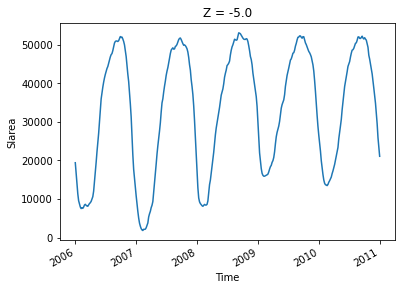

In [29]:
seaice_no05.sum(['XC', 'YC']).plot();

In [32]:
ice_anom = weighted_area.groupby('time.month') - weighted_area.groupby('time.month').mean()
ice_anom

<xarray.DataArray (time: 366, YC: 137, XC: 570)>
dask.array<getitem, shape=(366, 137, 570), dtype=float32, chunksize=(1, 137, 570), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12
Dimensions without coordinates: YC, XC

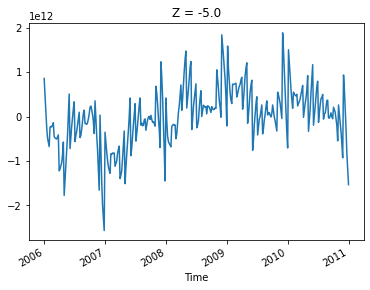

In [36]:
ice_anom.sum(['YC', 'XC']).plot()

In [37]:
si_index = ice_anom.sum(['YC', 'XC'])/ ice_anom.sum(['YC', 'XC']).std(dim='time')
si_index

<xarray.DataArray (time: 366)>
dask.array<truediv, shape=(366,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

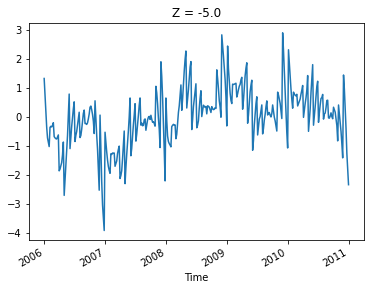

In [38]:
si_index.plot()

## SAM Index

In [38]:
url_ann = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/ann-seas-sam-57-07.csv'
ann_seas = pd.read_csv(url_ann, delim_whitespace=True, parse_dates=True, )
url_mo = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/mo-sam-57-07.csv'
mo = pd.read_csv(url_mo, delim_whitespace=True, parse_dates=True)

In [39]:
ann_seas.index = ann_seas.index.rename('time')
mo.index = mo.index.rename('time')

In [40]:
mo

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
time,,,,,,,,,,,,
1957-01-01,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958-01-01,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959-01-01,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960-01-01,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961-01-01,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018-01-01,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019-01-01,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78


In [41]:
#flattening dataframe by having next row go after the prev row, instead of col going after col
time = pd.date_range('1/1957', '1/2022', freq='M')
vector = np.array(mo.iloc[0])
for i in range(1,65):
    new_vec = np.array(mo.iloc[i])
    vector = np.append(vector,new_vec)

In [42]:
mo_xr = xr.DataArray(vector, coords=[time.rename('time')])

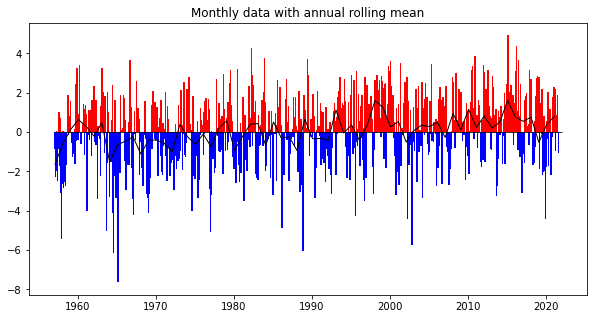

In [43]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.bar(time[np.where(mo_xr<0)], mo_xr.where(mo_xr < 0).dropna(dim='time'), color='b', width=70)
ax.bar(time[np.where(mo_xr>=0)], mo_xr.where(mo_xr >= 0).dropna(dim='time'), color='r', width=70)
ax.hlines(0, time[0], time[-1], colors='k', linewidth=0.8)
#mo_xr.rolling(time=12).mean().plot(color='k', linewidth=1)
plt.plot(time.values[np.arange(0, 780, 12)], mo_xr.groupby('time.year').mean().values, color='k', linewidth=1)
#mo_xr.groupby('time.year').mean().plot(color='k', linewidth=1)
plt.title('Monthly data with annual rolling mean');

## SAM & sea ice corr

In [44]:
seaice_no05.sum(['XC', 'YC'])

<xarray.DataArray 'SIarea' (time: 366)>
dask.array<sum-aggregate, shape=(366,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0

In [45]:
ann_seas.ANN.loc['2006':'2011']

time
2006-01-01    1.51
2007-01-01   -0.77
2008-01-01    2.28
2009-01-01    0.22
2010-01-01    3.28
2011-01-01    0.79
Name: ANN, dtype: float64

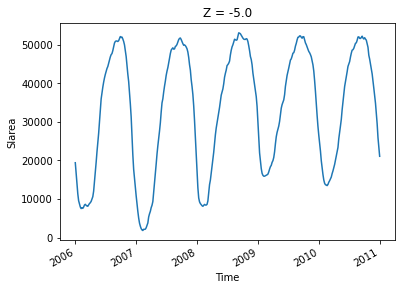

In [46]:
seaice_no05.sum(['XC', 'YC']).plot()
#ann_seas.ANN.loc['2006':'2011'].plot();

<AxesSubplot:xlabel='time'>

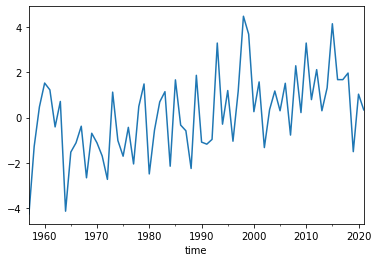

In [47]:
ann_seas.ANN.plot()

<AxesSubplot:xlabel='time'>

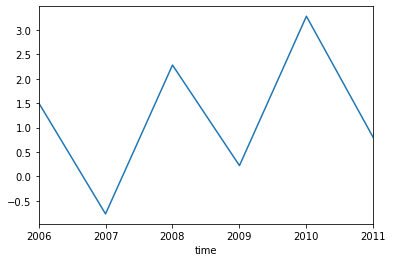

In [48]:
ann_seas.ANN.loc['2006':'2011'].plot()

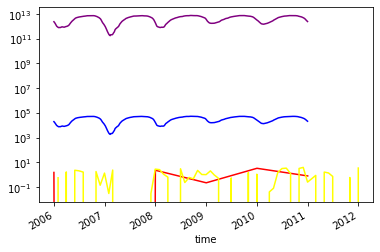

In [49]:
seaice_no05.sum(['XC', 'YC']).plot(color='blue')
weighted_area.sum(['XC', 'YC']).plot(color='purple')
ann_seas.ANN.loc['2006':'2011'].plot(color='red')
mo_xr.sel(time=slice('2006', '2011')).plot(color='yellow')
plt.yscale('log')

In [50]:
seaice_no05.sum(['XC', 'YC'])

<xarray.DataArray 'SIarea' (time: 366)>
dask.array<sum-aggregate, shape=(366,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0

In [51]:
mo_xr.sel(time=slice('2006', '2011'))

<xarray.DataArray (time: 72)>
array([ 0.56, -1.85,  1.66, -0.69,  2.28,  2.05,  1.61, -2.64, -0.26,
        1.79,  0.14,  1.34,  0.03,  2.36, -0.77, -0.33, -1.02, -0.65,
       -2.67, -0.28, -1.88, -0.86,  0.03,  2.8 ,  2.56,  1.09,  0.63,
       -0.81, -0.66,  3.  ,  0.23,  0.6 ,  0.46,  2.21,  1.03,  1.01,
        2.02,  0.94,  0.5 , -0.43, -0.14,  0.54, -0.13, -2.44, -0.78,
        1.47, -1.2 ,  1.09, -0.4 , -2.12,  0.04,  0.08,  1.51,  3.14,
        3.37,  1.24, -0.33,  3.19,  3.88,  0.25,  0.48,  0.87, -0.79,
        1.62,  1.37,  0.72, -1.52, -0.73, -1.79,  0.59, -1.41,  3.43])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-31 2006-02-28 ... 2011-12-31

In [52]:
mo_xr.time

<xarray.DataArray 'time' (time: 780)>
array(['1957-01-31T00:00:00.000000000', '1957-02-28T00:00:00.000000000',
       '1957-03-31T00:00:00.000000000', ..., '2021-10-31T00:00:00.000000000',
       '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1957-01-31 1957-02-28 ... 2021-12-31

<AxesSubplot:xlabel='time'>

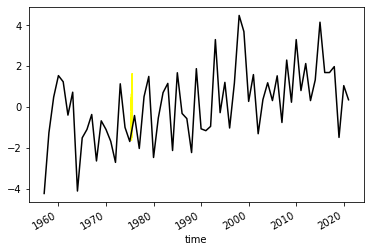

In [53]:
mo_xr.groupby('time.year').mean().plot(color='yellow')
ann_seas.ANN.plot(color='k')

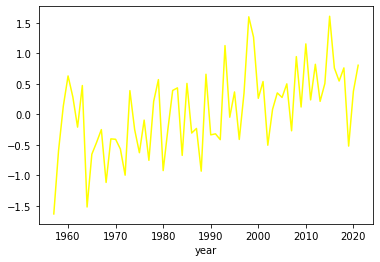

In [54]:
mo_xr.groupby('time.year').mean().plot(color='yellow')

In [55]:
no_seas = mo_xr.groupby('time.month') - mo_xr.groupby('time.month').mean(dim='time')
no_seas

<xarray.DataArray (time: 780)>
array([-1.25769231e+00, -1.95384615e+00,  7.55384615e-02, -2.11984615e+00,
       -2.40630769e+00, -1.11353846e+00,  9.19846154e-01, -1.66546875e+00,
        6.57343750e-01, -3.14296875e+00, -5.39859375e+00, -2.78375000e+00,
       -3.47692308e-01, -2.52384615e+00, -2.51446154e+00, -4.49846154e-01,
       -2.62630769e+00, -1.21353846e+00, -1.73015385e+00,  1.03453125e+00,
        1.83734375e+00, -1.82968750e-01,  3.21406250e-01,  6.66250000e-01,
        1.20230769e+00,  1.26153846e-01, -5.34461538e-01, -1.39984615e+00,
       -2.26307692e-01, -1.36353846e+00,  9.98461538e-02, -1.57546875e+00,
        2.39734375e+00, -4.82968750e-01,  3.30140625e+00, -5.33750000e-01,
        5.12307692e-01,  1.16615385e+00,  3.40553846e+00, -4.99846154e-01,
       -5.06307692e-01, -4.13538462e-01,  2.29846154e-01,  4.94531250e-01,
        1.34734375e+00, -1.19296875e+00,  1.20140625e+00,  1.20625000e+00,
        5.22307692e-01, -3.68384615e+00, -3.94461538e-01, -2.89846154e-01,
        1.21369231e+00, -6.43538462e-01,  8.99846154e-01,  1.16453125e+00,
       -1.27265625e+00,  1.61703125e+00,  1.54140625e+00,  2.16625000e+00,
        1.95230769e+00, -1.83846154e-01, -6.54461538e-01,  1.50015385e+00,
       -5.66307692e-01, -3.65353846e+00,  2.49846154e-01, -1.35468750e-01,
       -2.12656250e-01, -3.82968750e-01, -2.22859375e+00,  1.19625000e+00,
        2.87230769e+00,  1.72615385e+00,  2.03553846e+00,  1.26015385e+00,
       -9.96307692e-01,  1.57646154e+00,  3.29846154e-01, -4.96546875e+00,
...
        5.03692308e-01,  2.16646154e+00,  1.91984615e+00,  1.92453125e+00,
        1.84734375e+00, -6.82968750e-01,  1.48140625e+00,  5.66250000e-01,
        2.74230769e+00,  1.66615385e+00,  4.36553846e+00,  9.10153846e-01,
       -8.26307692e-01,  3.41646154e+00,  7.29846154e-01, -1.21546875e+00,
        2.39734375e+00, -9.12968750e-01, -3.09859375e+00, -1.67375000e+00,
       -1.50769231e+00, -7.73846154e-01, -1.55446154e+00,  1.50015385e+00,
        1.91369231e+00,  1.73646154e+00,  7.98461538e-02,  3.74531250e-01,
        3.57343750e-01, -6.62968750e-01,  3.20140625e+00,  1.28625000e+00,
        2.33230769e+00,  1.33615385e+00, -2.44615385e-02, -1.80984615e+00,
        1.03692308e-01, -1.81353846e+00,  4.69846154e-01, -7.15468750e-01,
        1.76734375e+00,  2.73703125e+00,  2.86140625e+00,  1.28625000e+00,
        2.40230769e+00, -1.55384615e+00,  1.47553846e+00,  7.10153846e-01,
       -1.63076923e-02,  1.96646154e+00, -2.28015385e+00, -1.97546875e+00,
        7.47343750e-01, -1.99296875e+00, -4.39859375e+00, -1.93375000e+00,
        1.82307692e-01, -4.38461538e-02,  2.05553846e+00, -1.86984615e+00,
        1.12369231e+00,  9.36461538e-01, -1.05015385e+00, -2.13546875e+00,
       -3.12656250e-01,  1.76703125e+00,  1.16140625e+00,  2.12625000e+00,
        1.56230769e+00,  2.50615385e+00, -9.44461538e-01,  7.20153846e-01,
        8.43692308e-01,  1.63646154e+00, -1.14015385e+00,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time     (time) datetime64[ns] 1957-01-31 1957-02-28 ... 2021-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

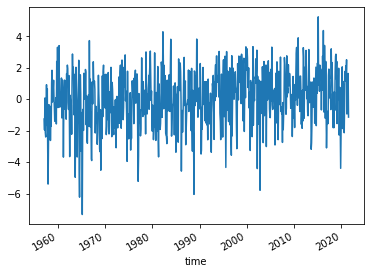

In [56]:
no_seas.plot();

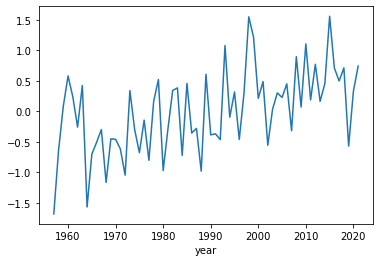

In [57]:
no_seas.groupby('time.year').mean().plot();

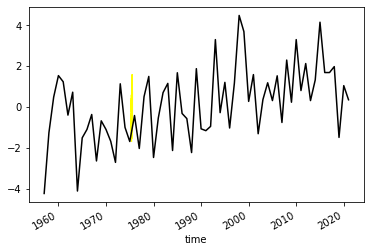

In [58]:
no_seas.groupby('time.year').mean().plot(color='yellow')
ann_seas.ANN.plot(color='k');

In [59]:
ann_seas.ANN

time
1957-01-01   -4.24
1958-01-01   -1.27
1959-01-01    0.47
1960-01-01    1.52
1961-01-01    1.22
              ... 
2017-01-01    1.67
2018-01-01    1.96
2019-01-01   -1.50
2020-01-01    1.03
2021-01-01    0.34
Name: ANN, Length: 65, dtype: float64

In [60]:
seaice_no05.interp(time = mo_xr.time.sel(time=slice('2006', '2011')))

<xarray.DataArray 'SIarea' (time: 72, YC: 137, XC: 570)>
dask.array<transpose, shape=(72, 137, 570), dtype=float32, chunksize=(72, 137, 570), chunktype=numpy.ndarray>
Coordinates:
    Z        float32 -5.0
  * time     (time) datetime64[ns] 2006-01-31 2006-02-28 ... 2011-12-31
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

In [61]:
ann_xr = ann_seas.ANN.to_xarray()

In [62]:
ann_xr.sel(time=slice('2006', '2011'))

<xarray.DataArray 'ANN' (time: 6)>
array([ 1.51, -0.77,  2.28,  0.22,  3.28,  0.79])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2007-01-01 ... 2011-01-01

In [63]:
mo_xr.sel(time=slice('2006', '2011'))

<xarray.DataArray (time: 72)>
array([ 0.56, -1.85,  1.66, -0.69,  2.28,  2.05,  1.61, -2.64, -0.26,
        1.79,  0.14,  1.34,  0.03,  2.36, -0.77, -0.33, -1.02, -0.65,
       -2.67, -0.28, -1.88, -0.86,  0.03,  2.8 ,  2.56,  1.09,  0.63,
       -0.81, -0.66,  3.  ,  0.23,  0.6 ,  0.46,  2.21,  1.03,  1.01,
        2.02,  0.94,  0.5 , -0.43, -0.14,  0.54, -0.13, -2.44, -0.78,
        1.47, -1.2 ,  1.09, -0.4 , -2.12,  0.04,  0.08,  1.51,  3.14,
        3.37,  1.24, -0.33,  3.19,  3.88,  0.25,  0.48,  0.87, -0.79,
        1.62,  1.37,  0.72, -1.52, -0.73, -1.79,  0.59, -1.41,  3.43])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-31 2006-02-28 ... 2011-12-31

In [65]:
seaice_no05.time

<xarray.DataArray 'time' (time: 366)>
array(['2006-01-01T00:00:00.000000000', '2006-01-06T00:00:00.000000000',
       '2006-01-11T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [66]:
corr_si_timeinterp = xr.corr(seaice_no05.sum(['XC','YC']).interp(time = mo_xr.time.sel(time=slice('2006', '2011'))),
               mo_xr.sel(time=slice('2006', '2011')), dim='time').values
corr_si_timeinterp

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


array(-0.06064425)

In [55]:
corr_mo = xr.corr(seaice_no05.sum(['XC','YC']), mo_xr.sel(time=slice('2006', '2011')), dim='time').values
corr_mo

array(-0.12012728)

In [58]:
corr_ann = xr.corr(seaice_no05.sum(['XC','YC']), ann_xr.sel(time=slice('2006', '2011')), dim='time').values
corr_ann

array(0.86229934)

### **SOSE's sea ice extent is strongly correlated with SAM index between 2006 through 2010**

## Saving Data

In [66]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [79]:
seaice_file1 = seaice.to_dataset(name='seaice')
seaice_file2 = seaice_no05.to_dataset(name='seaice_no05')

In [81]:
seaice_file2

<xarray.Dataset>
Dimensions:      (XC: 570, YC: 95, time: 366)
Coordinates:
  * time         (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z            float32 -5.0
Dimensions without coordinates: XC, YC
Data variables:
    seaice_no05  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>

In [85]:
#uploading seaice WITH polynya year
gcsmap_seaice1 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/seaicefiles/seaice.zarr')
seaice_file1.to_zarr(gcsmap_seaice1, mode='w')

In [84]:
#uploading seaice WITHOUT polynya year
gcsmap_seaice2 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/seaicefiles/seaice_no05.zarr')
seaice_file2.to_zarr(gcsmap_seaice2, mode='w')